# MVC project: Compare results
- [GitHub](https://github.com/romainmartinez/mvc)

## Todo:
- test XGBoost
- add tests images
- article:
    - w/ 5 tests and this method: 93%
    - w/ 5 tests and old method: 85%
    - to get same metrics without prediction, need 12 tests

## 0. Setup

In [ ]:
# Common imports
import pandas as pd
pd.set_option('display.float_format', '{:.5f}'.format)
import numpy as np
import os
import time

# the 'mvc' directory contains functions used but not necessary to understand the story
import mvc

# Figures
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Load data

In [2]:
df = pd.read_hdf('mvc.h5')
df.head()

,upper trapezius,middle trapezius,lower trapezius,anterior deltoid,middle deltoid,posterior deltoid,pectoralis major,serratus anterior,latissimus dorsi,supraspinatus,...,8,9,10,11,12,13,14,15,max,best_test
0,1,0,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.10418,4
1,0,1,0,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13563,1
2,0,0,1,0,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.30076,2
3,0,0,0,1,0,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.26212,3
4,0,0,0,0,1,0,0,0,0,0,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.17047,2


### Drop tests
*see '`2_select_test.ipynb`' notebook*

In [3]:
# tests to drop according to previous analysis (2_select_test.ipynb)
to_keep = np.array(['4', '3', '2', '0', '5']).astype(int)
to_drop = np.delete(np.arange(16), to_keep)
df.drop(to_drop, axis=1, inplace=True)

### Normalization

In [4]:
# normalization with the fourth test
four = df[4].copy()
ref = 4
normalize = lambda x: x * 100 / x[ref]
# normalize = lambda x: x * 100 / x.max()

df.iloc[:, 13:-1] = df.iloc[:, 13:-1].apply(normalize, axis=1)

In [5]:
# remove muscles
muscles_to_remove = ['pectoralis major'] # 10.50

index = []

for i in muscles_to_remove:
    idx = df[i] == 1
    index.extend(idx[idx].index)
df.drop(index, inplace=True, axis=0)

removed 69 rows


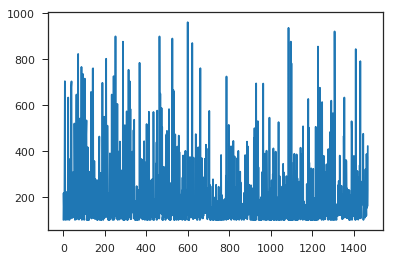

In [6]:
# remove outliers
threshold = 1000
rows_to_drop = (df['max'] == np.inf) | (df['max'] > threshold)
df.drop(rows_to_drop[rows_to_drop].index, inplace=True, axis=0)
print(f'removed {np.sum(rows_to_drop)} rows')
df['max'].plot()
plt.show()

## 2. Split the data

### Stratified Train Test Split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_labels = list(df.drop(['max', 'muscle', 'best_test'], axis=1).columns)
y_labels = ['max']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[X_labels], df[y_labels],
                                                        test_size=0.2, random_state=RANDOM_SEED,
                                                        stratify=df['muscle'])

## 3. Train Models

In [10]:
from sklearn.ensemble import ExtraTreesRegressor

param_grid = {
    'bootstrap': False,
    'criterion': 'mse',
    'max_features': 14,
    'n_estimators': 45,
    'random_state': RANDOM_SEED
}

model = ExtraTreesRegressor(**param_grid)

In [16]:
model.fit(X_train, np.ravel(y_train))
ML4 = model.predict(X_test)

temp = y_test.join(four.loc[y_test.index])
# reverse normalization
denormalize = lambda x: x * x[4] / 100 
# normalize = lambda x: x * 100 / x.max()

temp = temp.apply(denormalize, axis=1)

In [16]:
temp

,max,4
683,0.09090,0.00005
1064,0.12026,0.00006
242,0.11820,0.00000
359,0.28934,0.00045
587,0.00014,0.00000
571,0.00007,0.00000
744,0.38408,0.00148
888,0.00075,0.00000
909,0.00162,0.00000
532,0.00002,0.00000


In [24]:
y_test * df.loc[y_test.index][4] / 100

SyntaxError: invalid syntax (<ipython-input-24-0eb5f20e1e52>, line 1)

In [19]:
ref = y_test * df.loc[y_test.index][4] 

/home/romain/miniconda3/envs/mvc/lib/python3.6/site-packages/pandas/core/indexes/base.py:3137: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


# 4. Compare results

In [12]:
df = pd.read_hdf('mvc.h5').drop('best_test', axis=1)
muscle = df['muscle']


to_keep = np.array([11, 12, 13, 14])
to_drop = np.delete(np.arange(16), to_keep)
NT4 = df.drop(to_drop, axis=1).drop('muscle', axis=1)
NT4_test = NT4.loc[X_test.index]

to_keep = np.array([2, 5, 7, 14])
to_drop = np.delete(np.arange(16), to_keep)
DA4 = df.drop(to_drop, axis=1).drop('muscle', axis=1)
DA4_test = DA4.loc[X_test.index]

to_keep = np.array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 13, 14])
to_drop = np.delete(np.arange(16), to_keep)
DA12 = df.drop(to_drop, axis=1).drop('muscle', axis=1)
DA12_test = DA12.loc[X_test.index]

In [13]:
NT4_test

,upper trapezius,middle trapezius,lower trapezius,anterior deltoid,middle deltoid,posterior deltoid,pectoralis major,serratus anterior,latissimus dorsi,supraspinatus,infraspinatus,subscapularis,11,12,13,14,max
683,0,0,0,0,1,0,0,0,0,0,0,0,0.09090,0.00727,0.02664,0.06513,0.09090
1064,0,0,0,0,0,0,0,0,0,1,0,0,0.00000,0.00000,0.00000,0.00000,0.12026
242,0,0,0,0,0,0,0,0,1,0,0,0,0.00000,0.00000,0.00000,0.01461,0.11820
359,0,0,1,0,0,0,0,0,0,0,0,0,0.26812,0.03326,0.10216,0.28934,0.28934
587,0,0,0,0,1,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00014
571,0,0,1,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00007
744,1,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.01123,0.38408
888,0,0,0,0,0,0,0,0,0,0,0,1,0.00000,0.00000,0.00028,0.00000,0.00075
909,0,0,0,0,0,0,0,0,0,0,1,0,0.00000,0.00000,0.00023,0.00000,0.00162
532,0,0,1,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00002
